In [1]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../code/')
%matplotlib inline
import itertools
from pathlib import Path
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test
from sklearn.metrics import mean_absolute_error
import os

In [3]:
dataset = 3
# cnn-individual&cnn-tree best parameters
best_cnn_individual = np.load("../code/baseline/result/cnn-individual-param-{}.npy".format(dataset)).item()
best_cnn_tree = np.load("../code/baseline/result/cnn-tree-param-{}.npy".format(dataset)).item()

In [4]:
# get prediction for cnn individual
cnn_individual_pred = {}
cnn_individual_error = {}
for fold_num in range(5):
    cnn_individual_error[fold_num] = {}
    cnn_individual_pred[fold_num] = {}
    for appliance in ['hvac', 'fridge', 'dr', 'dw', 'mw']:
        iters= best_cnn_individual[appliance][fold_num]['iters']
        lr = best_cnn_individual[appliance][fold_num]['lr']

        directory = "../code/baseline/cnn-tree/{}/{}/{}/200000/0.0/".format(dataset, fold_num, lr)
        filename = "test-pred-[\'{}\'].npy".format(appliance)
        full_path = directory + filename
        cnn_individual_pred[fold_num][appliance] = np.array(np.load(full_path).item()[iters]).reshape(-1, 1,112,24)

        filename = "test-error-[\'{}\'].npy".format(appliance)
        full_path = directory + filename
        cnn_individual_error[fold_num][appliance] = np.load(full_path).item()[iters][appliance]


In [5]:
# get prediction for cnn tree
cnn_tree_pred = {}
cnn_tree_error = {}
for fold_num in range(5):
    cnn_tree_pred[fold_num] = {}
#     cnn_tree_error[fold_num] = {}
    iters = best_cnn_tree[fold_num]['iters']
    order = best_cnn_tree[fold_num]['order']
    lr = best_cnn_tree[fold_num]['lr']
    print(order)


    cnn_pred = np.load("../code/baseline/cnn-tree/{}/{}/{}/20000/0.0/test-pred-[\'{}\'].npy".format(dataset, fold_num, lr, str(order)[2:-2])).item()
    cnn_tree_error[fold_num] = np.load("../code/baseline/cnn-tree/{}/{}/{}/20000/0.0/test-error-[\'{}\'].npy".format(dataset, fold_num, lr, str(order)[2:-2])).item()[iters]
    # order = ['dw', 'dr', 'hvac', 'fridge', 'mw']
#     cnn_tree_pred = {}
    for idx, appliance in enumerate(order):
#         print(idx, appliance)
        cnn_tree_pred[fold_num][appliance] = cnn_pred[iters][idx].reshape(-1, 1, 112,24)

('fridge', 'mw', 'hvac', 'dw', 'dr')
('dw', 'hvac', 'fridge', 'mw', 'dr')
('fridge', 'mw', 'dr', 'hvac', 'dw')
('dw', 'dr', 'hvac', 'mw', 'fridge')
('dr', 'hvac', 'mw', 'dw', 'fridge')


In [6]:
true = {}
arti = {}
res = {}
for fold_num in range(5):
    train, true[fold_num] = get_train_test(3, 5, fold_num) 
    train, arti[fold_num] = get_train_test(1, 5, fold_num)
    res[fold_num] = true[fold_num][:, 0] - arti[fold_num][:, 0]

In [7]:
res[0].mean(axis=2).shape

(14, 112)

In [8]:
res_vec = []
for fold_num in range(5):
    res_vec = np.append(res_vec, res[fold_num].mean(axis=2).reshape(1, -1))

In [9]:
aggregate = []
for fold_num in range(5):
    aggregate = np.append(aggregate, true[fold_num][:, 0].mean(axis=2).reshape(1, -1))

In [28]:
hvac = []
for fold_num in range(5):
    hvac = np.append(hvac, true[fold_num][:, 1].mean(axis=2).reshape(1, -1))

In [10]:
#hvac error
hvac_error = []
for fold_num in range(5):
    hvac_res = np.abs(cnn_individual_pred[fold_num]['hvac'].reshape(-1, 24) - true[fold_num][:, 1].reshape(-1, 24))
    hvac_error = np.append(hvac_error, hvac_res.mean(axis=1).reshape(1, -1))

In [11]:
#hvac
fridge_error = []
for fold_num in range(5):
    fridge_res = np.abs(cnn_individual_pred[fold_num]['fridge'].reshape(-1, 24) - true[fold_num][:, 2].reshape(-1, 24))
    fridge_error = np.append(fridge_error, fridge_res.mean(axis=1).reshape(1, -1))

In [58]:
data = {}
data['aggregate consumption'] = aggregate.T
data['residual'] = res_vec
data['hvac error'] = hvac_error
# data['fridge error'] = fridge_error
data['hvac consumption'] = hvac

In [59]:
pd.DataFrame(data).T

,0,1,2,3,4,5,6,7,8,9,...,7606,7607,7608,7609,7610,7611,7612,7613,7614,7615
aggregate consumption,2048.072226,2080.802776,1809.552085,1835.252084,1343.568750,1236.034720,844.150698,918.160416,1722.238899,1352.090267,...,1646.990966,1602.159730,1707.909032,1586.276395,1385.226390,1444.486811,1395.231955,1785.702054,1343.685417,1594.588196
hvac consumption,991.640981,900.842355,854.448615,811.787496,535.232640,623.408339,345.457638,404.977776,544.776396,418.368056,...,1041.979162,1065.440276,1045.708327,973.945135,901.152772,839.681952,831.234715,949.498605,724.387502,1018.204864
hvac error,246.419753,222.137414,185.576459,214.511628,214.957304,146.862074,168.480560,147.195958,307.569729,263.282663,...,252.211665,235.000568,300.197740,248.846409,246.097464,185.432367,250.625342,214.430687,178.772598,172.095075
residual,752.156241,920.467368,818.780555,627.690283,503.512499,451.298604,381.147227,357.570141,898.529171,776.663878,...,476.714583,444.167371,480.129871,523.643760,408.180562,493.933333,475.777100,539.998587,513.105554,500.511804


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(df[0], df[2], alpha=0.5)
plt.xlabel("average residual")
plt.ylabel("average hvac error")
plt.show()

NameError: name 'df' is not defined

In [ ]:
import seaborn as sns; sns.set()
# sns.palplot(sns.cubehelix_palette())
cmap = sns.cubehelix_palette(as_cmap=True)
sns.heatmap(pd.DataFrame(data).corr(), cmap=cmap, annot=True)

In [4]:
tensor = np.load("../2015-5appliances-true-agg.npy")

In [38]:
topk = pd.Series(res_vec).nlargest(5).index.tolist()
lastk = pd.Series(res_vec).nsmallest(5).index.tolist()

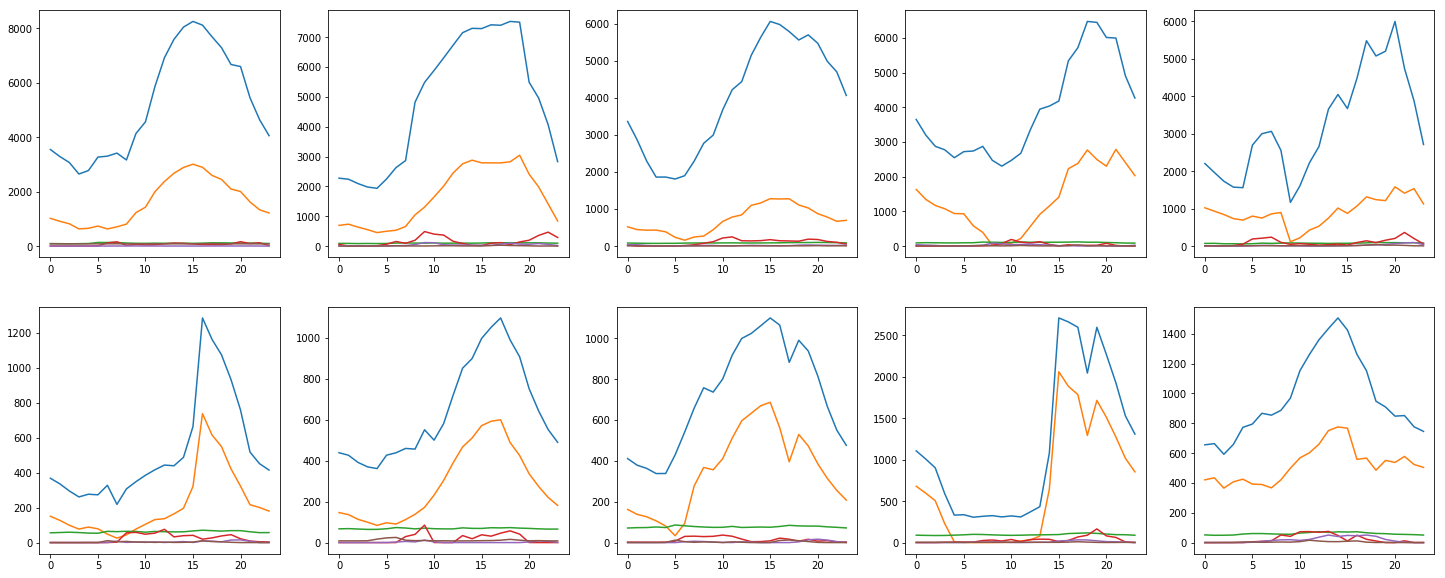

In [50]:
import seaborn as sns
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize=(25, 10))
ax = axes.flatten()
fold_num = 0

for i, home_id in enumerate(topk):
    pd.DataFrame(tensor[home_id].mean(axis=1)).T.plot(ax=ax[i], legend=False)
for i, home_id in enumerate(lastk):
    pd.DataFrame(tensor[home_id].mean(axis=1)).T.plot(ax=ax[i+5], legend=False)

In [244]:
topk = pd.Series(hvac_error).nlargest(200).index.tolist()
lastk = pd.Series(hvac_error).nsmallest(10).index.tolist()

In [234]:
112*60

6720

In [235]:
112*61

6832

In [245]:
len([x for x in topk if x <6832 and x >= 6720])

69

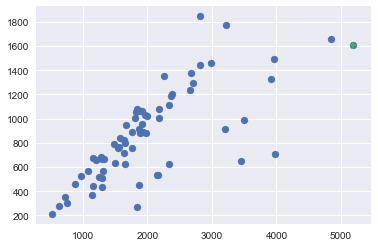

In [261]:
agg_mean = tensor[:, 0].mean(axis=1).mean(axis=1)
hvac_mean = tensor[:, 1].mean(axis=1).mean(axis=1)
plt.scatter(agg_mean, hvac_mean)
plt.scatter(agg_mean[60], hvac_mean[60], marker='+')

In [70]:
new_tensor = np.swapaxes(tensor, 1, 2)

In [230]:
pd.DataFrame(hvac_error.reshape(68, -1)).drop(60).mean().mean()

290.39751574695816

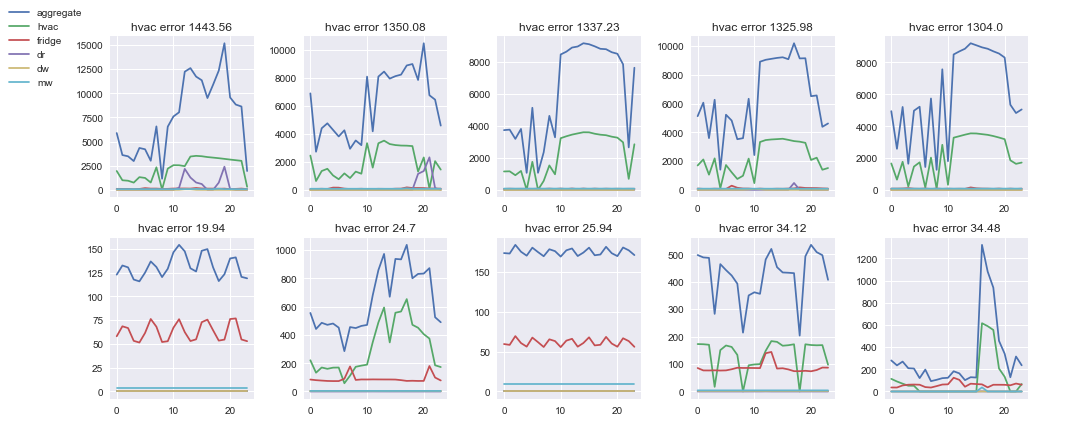

In [87]:
import seaborn as sns
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize=(15, 6))
ax = axes.flatten()
fold_num = 0
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

for i, home_id in enumerate(topk):
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id].T).plot(ax=ax[i], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
# ax[i].legend()

for i, home_id in enumerate(lastk):
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id].T).plot(ax=ax[i+5], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))

handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, ['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw'], loc='upper center', mode="expand")

In [101]:
hvac_pred = np.array([], dtype=np.int64).reshape(0,24)
for fold_num in range(5):
    hvac_pred = np.concatenate((hvac_pred, cnn_individual_pred[fold_num]['hvac'].reshape(-1, 24)))

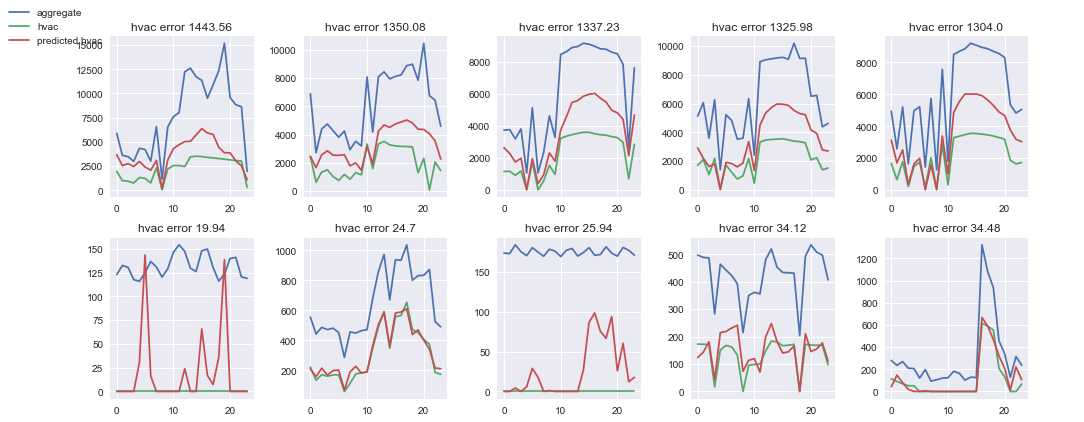

In [106]:
import seaborn as sns
fig, axes = plt.subplots(ncols=5, nrows = 2, figsize=(15, 6))
ax = axes.flatten()
fold_num = 0
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

for i, home_id in enumerate(topk):
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id][0].T).plot(ax=ax[i], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id][1].T).plot(ax=ax[i], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
    pd.DataFrame(hvac_pred[home_id]).plot(ax=ax[i], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
# ax[i].legend()

for i, home_id in enumerate(lastk):
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id][0].T).plot(ax=ax[i+5], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
    pd.DataFrame(new_tensor.reshape(-1, 6, 24)[home_id][1].T).plot(ax=ax[i+5], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))
    pd.DataFrame(hvac_pred[home_id]).plot(ax=ax[i+5], legend=False, title="hvac error {}".format(round(hvac_error[home_id], 2)))

handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, ['aggregate', 'hvac','predicted hvac',  'dr', 'dw', 'mw'], loc='upper center', mode="expand")

In [117]:
st = pd.HDFStore(os.path.expanduser("../all.h5"), mode='r')

In [126]:
dataid = np.load("./homeid_10_hourly.npy")
validid = np.load("./valid_homes_index.npy")
validhome = dataid[validid]

In [153]:
validhome[60]

3916

In [151]:
new_tensor.reshape(-1, 6, 24)[6720][1]

array([    0.        ,     0.        ,  1871.13330078,     0.        ,
           0.        ,   123.53333282,  1092.33337402,     0.        ,
        1062.05004883,   610.31665039,  2055.26660156,  1884.69995117,
        2852.55004883,  1976.5333252 ,  3241.28344727,  3174.98339844,
        3156.81665039,  3126.63330078,  1587.61669922,  2226.63330078,
         547.84997559,  2364.63330078,     0.        ,  1536.48327637])

In [178]:
tensor[60,  1][111]

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,   883.2833252 ,     0.        ,
           0.        ,     0.        ,  1494.16662598,   773.83331299,
        2643.68334961,  1138.61669922,  3269.35009766,  3033.76660156,
        2962.14990234,  1594.59997559,  1320.5333252 ,   981.29998779,
        1460.01672363,    25.89999962,  1141.91662598,     0.        ])

In [6]:
tensor[60].shape

(6, 112, 24)

In [3]:
tensor = np.load("../2015-5appliances-true-agg-residual.npy")

0 aggregate
1 hvac
2 fridge
3 dr
4 dw
5 mw
6 residual


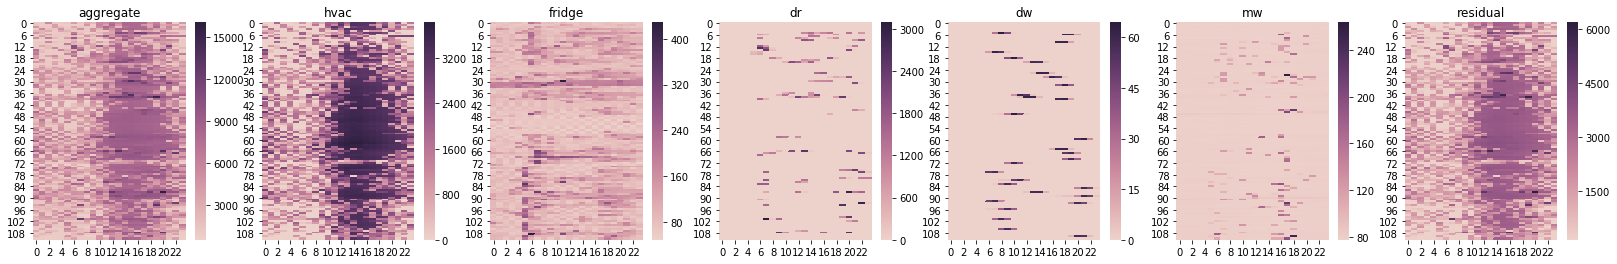

In [4]:
cmap = sns.cubehelix_palette(as_cmap=True)
fig, axes = plt.subplots(ncols=7, nrows = 1, figsize=(28, 4))
ax = axes.flatten()

for idx, appliance in enumerate(APPLIANCE_ORDER[:]):
    print(idx, appliance)
    
    sns.heatmap(tensor[60][idx], ax=ax[idx], cmap=cmap)
    ax[idx].set_title(appliance)

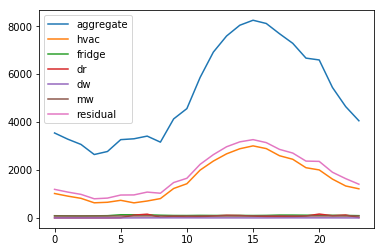

In [9]:
ax = pd.DataFrame(tensor[60].mean(axis=1)).T.plot()
ax.legend(['aggregate', 'hvac', 'fridge', 'dr', 'dw', 'mw', 'residual'])

In [221]:
st['3916']['2015']

,use,air1,clotheswasher1,dishwasher1,drye1,furnace1,kitchenapp1,kitchenapp2,lights_plugs1,microwave1,range1,refrigerator1
localhour,,,,,,,,,,,,
2015-01-01 00:00:00-06:00,2555.949951,0.0,0.0,0.000000,0.000000,323.816681,NaN,NaN,524.433350,73.550003,10.333333,134.266663
2015-01-01 01:00:00-06:00,2467.300049,0.0,0.0,0.000000,0.000000,361.950012,NaN,NaN,523.283325,73.449997,10.000000,65.066666
2015-01-01 02:00:00-06:00,2403.100098,0.0,0.0,0.000000,0.000000,298.700012,NaN,NaN,531.166687,73.516670,10.116667,90.300003
2015-01-01 03:00:00-06:00,2669.199951,0.0,0.0,0.000000,0.000000,331.049988,NaN,NaN,661.283325,73.500000,10.366667,60.200001
2015-01-01 04:00:00-06:00,2110.550049,0.0,0.0,0.000000,0.000000,349.700012,NaN,NaN,305.416656,73.433334,10.000000,96.050003
2015-01-01 05:00:00-06:00,1813.033325,0.0,0.0,0.000000,0.000000,245.233337,NaN,NaN,295.733337,73.583336,10.000000,76.366669
2015-01-01 06:00:00-06:00,1904.233276,0.0,0.0,0.000000,0.000000,311.799988,NaN,NaN,294.783325,73.466667,10.000000,60.133335
2015-01-01 07:00:00-06:00,2026.449951,0.0,0.0,0.000000,0.000000,351.700012,NaN,NaN,294.149994,73.383331,10.000000,83.150002
2015-01-01 08:00:00-06:00,1755.416626,0.0,0.0,0.000000,0.000000,266.083344,NaN,NaN,279.616669,73.366669,9.750000,54.916668


In [ ]:
[6758, 6796, 6769, 6767, 6768, 6759, 6757, 6751, 6772, 6770]

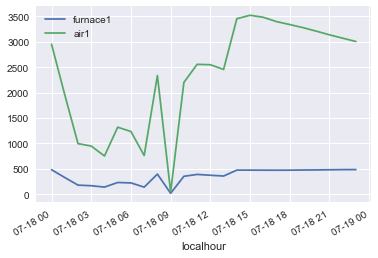

In [206]:
ax=st['3916']['2015-07-18']['furnace1'].plot(legend='furnace')
st['3916']['2015-07-18']['air1'].plot(ax=ax, legend='hvac')

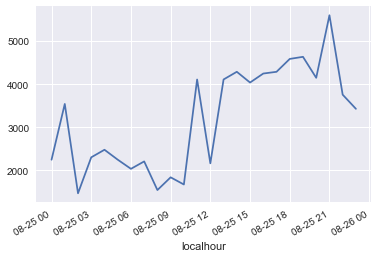

In [219]:
(st['3916']['2015-08-25']['use'] - st['3916']['2015-08-25'].drop('use', axis=1).sum(axis=1)).plot()

In [232]:
c = 0
for hid in validhome:
    try:
        print(hid, st[str(hid)]['2015-06-10':'2015-09-29']['furnace1'].mean())
        print(hid, st[str(hid)]['2015-06-10':'2015-09-29']['air1'].mean())
        c += 1
    except:
        continue
print(c)
# st['3916']['2015']['furnace1'].max()

114 262.39410400390625
114 877.852783203125
661 280.25482177734375
661 1185.808837890625
2018 408.2294006347656
2018 1329.1531982421875
2575 326.0294494628906
2575 890.2872314453125
2814 255.98907470703125
2814 1005.4513549804688
2859 125.24154663085938
2859 282.1856994628906
3456 186.21507263183594
3456 658.0193481445312
3482 198.25833129882812
3482 441.81939697265625
5403 193.71224975585938
5403 757.6370239257812
6836 184.75198364257812
6836 371.25927734375
6990 264.0881042480469
6990 888.6303100585938
7536 391.4953918457031
7536 1063.3985595703125
7940 236.9931640625
7940 452.6778869628906
8236 197.2777557373047
8236 796.4246826171875
9134 337.8026428222656
9134 624.1229248046875
8188 181.4915313720703
8188 569.7628173828125
2156 103.00330352783203
2156 766.750244140625
4220 189.3968505859375
4220 880.0401611328125
7951 51.22779083251953
7951 537.6946411132812
2094 521.176025390625
2094 1769.800048828125
93 290.6458435058594
93 1053.204345703125
871 130.00802612304688
871 521.294433